**libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [3]:
# Load the dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Extract features and labels
X_train = train_data.iloc[:, 1:3].values  # Adjust indices based on dataset
y_train = train_data.iloc[:, 3].values
X_test = test_data.iloc[:, 1:3].values
y_test = test_data.iloc[:, 3].values

# Define evaluation function
def evaluate_model_manual(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Train Precision": precision_score(y_train, y_train_pred, average="binary"),
        "Test Precision": precision_score(y_test, y_test_pred, average="binary"),
        "Train Recall": recall_score(y_train, y_train_pred, average="binary"),
        "Test Recall": recall_score(y_test, y_test_pred, average="binary"),
        "Train F1 Score": f1_score(y_train, y_train_pred, average="binary"),
        "Test F1 Score": f1_score(y_test, y_test_pred, average="binary"),
    }
    return metrics

# Define bootstrap sampling function
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, n_samples, replace=True)
    return X[indices], y[indices]


def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    # Set range for 2D data (for both features)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a grid to draw the decision boundary
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Prediction on the network
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Draw the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.75)
    
    # Plot the data
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=40)
    plt.legend(*scatter.legend_elements(), title="Classes")
    
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")


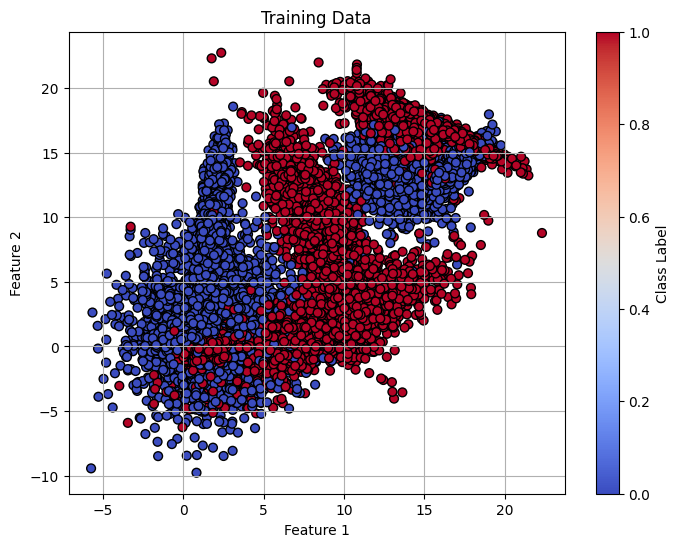

Class 1: 12016
Class 0: 11984


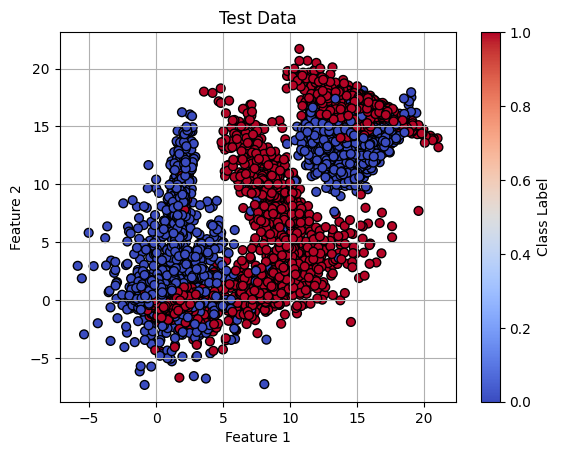

Class 0: 3015
Class 1: 2985


In [4]:
plt.figure(figsize=(8, 6))

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', edgecolor='k', s=40)

plt.title("Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class Label") 
plt.grid(True)
plt.show()

Trd = train_data['cls'].value_counts()
for cls, count in Trd.items():
    print(f"Class {cls}: {count}")


plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', edgecolor='k', s=40)

plt.title("Test Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class Label") 
plt.grid(True)
plt.show()

Ted = test_data['cls'].value_counts()
for cls, count in Ted.items():
    print(f"Class {cls}: {count}")

**Phase 1**

Best Parameters: {'n_estimators': 60, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10}
Best Training Accuracy: 0.9074166666666666
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.9052
Test Accuracy       : 0.8672
Train Precision     : 0.8968
Test Precision      : 0.8554
Train Recall        : 0.9161
Test Recall         : 0.8821
Train F1 Score      : 0.9063
Test F1 Score       : 0.8685
------------------------------




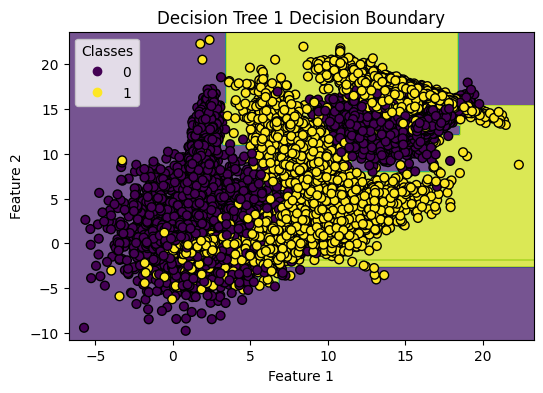

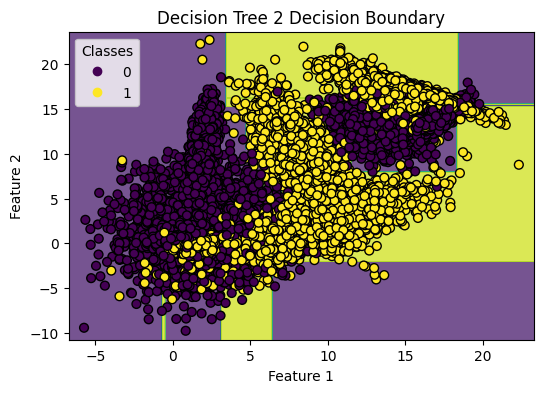

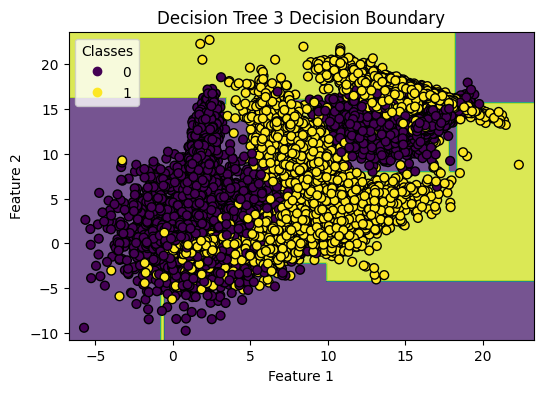

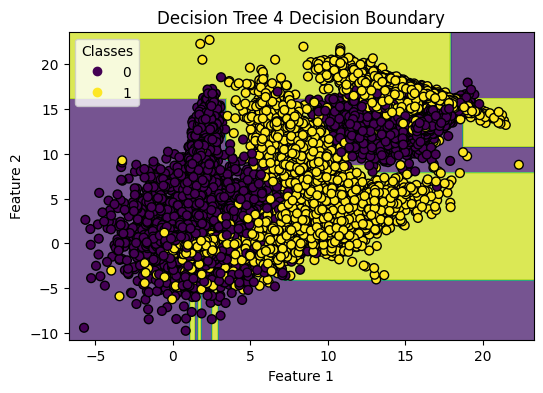

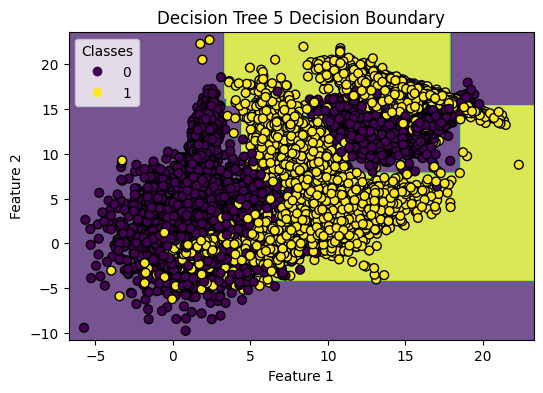

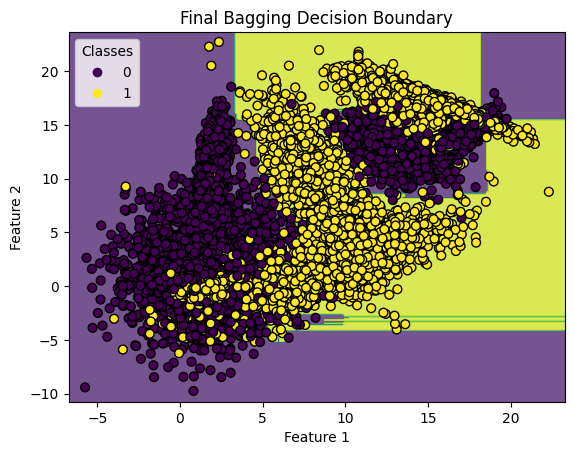

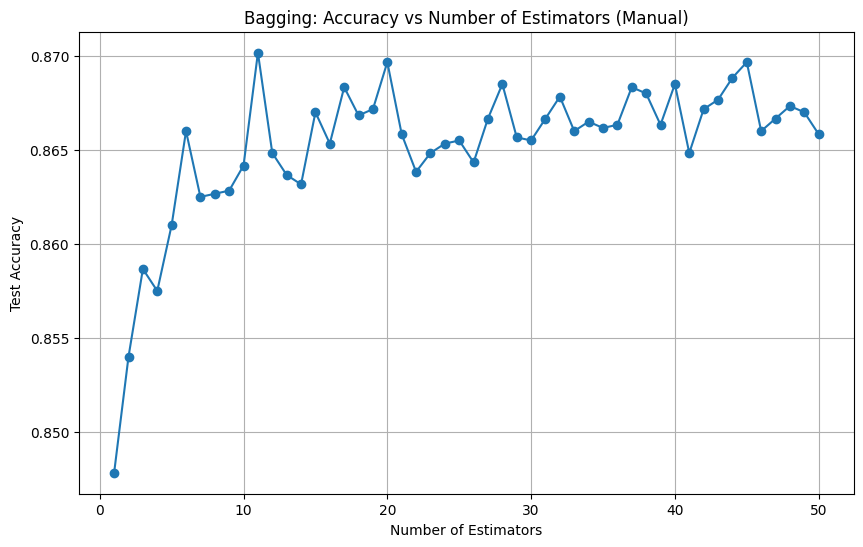

In [5]:
# Define Manual Bagging Class
class ManualBagging:
    def __init__(self, base_estimator, n_estimators):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            X_sample, y_sample = bootstrap_sample(X, y)
            # Train the base model on the sample
            model = self.base_estimator()
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        # Collect predictions from all base models
        predictions = np.array([model.predict(X) for model in self.models])
        # Use majority voting for final prediction
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# Define hyperparameter tuning for Bagging
def tune_bagging_hyperparameters(X_train, y_train):
    # Base estimator parameters
    base_estimator_params = {
        'max_depth': [5, 10, 15],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [10, 15, 20]
    }

    # Number of estimators to test
    n_estimators_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Grid Search for Base Estimator
    best_params = None
    best_score = 0

    for n_estimators in n_estimators_list:
        for max_depth in base_estimator_params['max_depth']:
            for min_samples_split in base_estimator_params['min_samples_split']:
                for min_samples_leaf in base_estimator_params['min_samples_leaf']:
                    # Update base estimator with current params
                    def create_base_estimator():
                        return DecisionTreeClassifier(
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            random_state=42
                        )

                    # Train Bagging with tuned base estimator
                    bagging_model = ManualBagging(base_estimator=create_base_estimator, n_estimators=n_estimators)
                    bagging_model.fit(X_train, y_train)

                    # Evaluate
                    y_pred = bagging_model.predict(X_train)
                    accuracy = (y_pred == y_train).mean()

                    if accuracy > best_score:
                        best_score = accuracy
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }

    print("Best Parameters:", best_params)
    print("Best Training Accuracy:", best_score)

    return best_params

# Perform hyperparameter tuning
best_params = tune_bagging_hyperparameters(X_train, y_train)

# Use tuned hyperparameters in the final model
def create_tuned_base_estimator():
    return DecisionTreeClassifier(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

# Final Bagging Model with tuned parameters
final_bagging_model = ManualBagging(base_estimator=create_tuned_base_estimator, n_estimators=best_params['n_estimators'])
final_bagging_model.fit(X_train, y_train)

# Evaluate final model
metrics = evaluate_model_manual(final_bagging_model, X_train, y_train, X_test, y_test)

print("Evaluation Metrics:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:<20}: {value:.4f}")
print("-" * 30)
print("\n")

# Visualize individual decision boundaries
n_visualize = 5
for i in range(min(n_visualize, len(final_bagging_model.models))):
    plt.figure(figsize=(6, 4))
    plot_decision_boundary(final_bagging_model.models[i], X_train, y_train, \
                           title=f"Decision Tree {i+1} Decision Boundary")
    plt.show()

# Visualize final Bagging decision boundary
plot_decision_boundary(final_bagging_model, X_train, y_train, \
                               title="Final Bagging Decision Boundary")

# Plot accuracy vs number of estimators
bagging_scores = []
for n_estimators in range(1, 101):
    bagging_model = ManualBagging(base_estimator=create_tuned_base_estimator, n_estimators=n_estimators)
    bagging_model.fit(X_train, y_train)
    metrics = evaluate_model_manual(bagging_model, X_train, y_train, X_test, y_test)
    bagging_scores.append((n_estimators, metrics["Test Accuracy"]))

plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in bagging_scores], [x[1] for x in bagging_scores], marker='o')
plt.title("Bagging: Accuracy vs Number of Estimators (Manual)")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


**Phase 2**

Best Hyperparameters: {'n_estimators': 90, 'max_features': 2, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}
Best Test Accuracy: 0.8733333333333333
Evaluation Metrics:
------------------------------
Train Accuracy      : 0.8847
Test Accuracy       : 0.8690
Train Precision     : 0.8795
Test Precision      : 0.8613
Train Recall        : 0.8919
Test Recall         : 0.8781
Train F1 Score      : 0.8856
Test F1 Score       : 0.8696
------------------------------


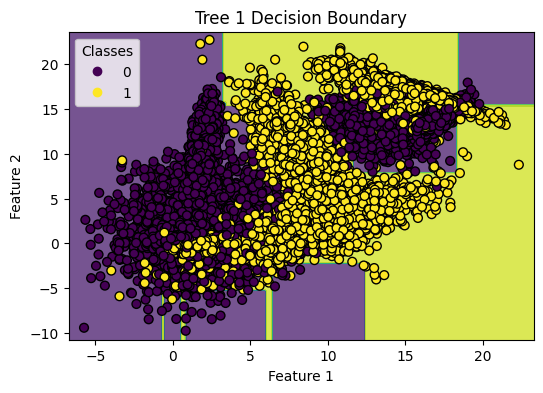

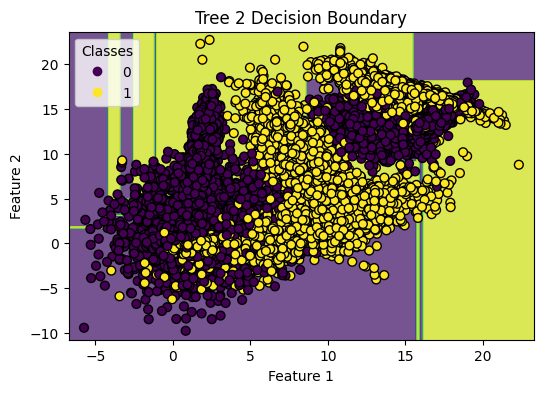

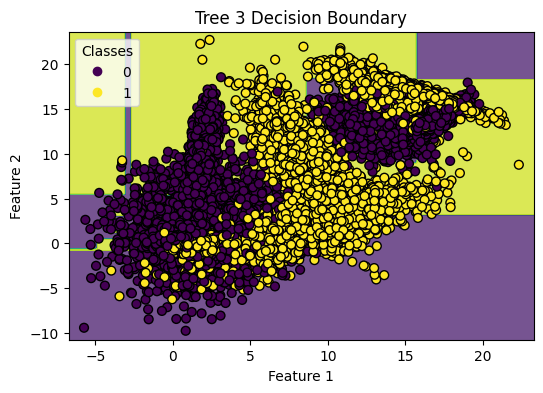

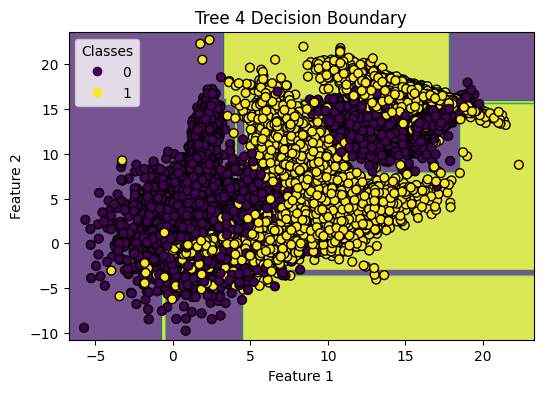

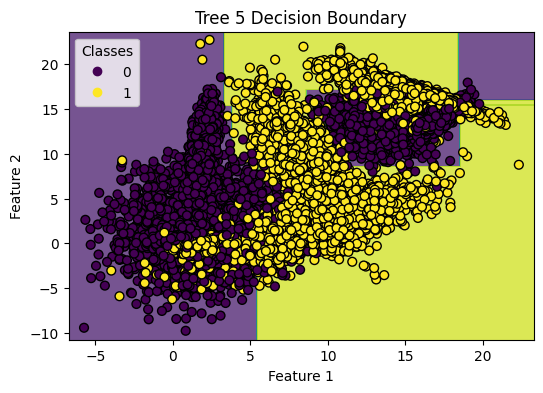

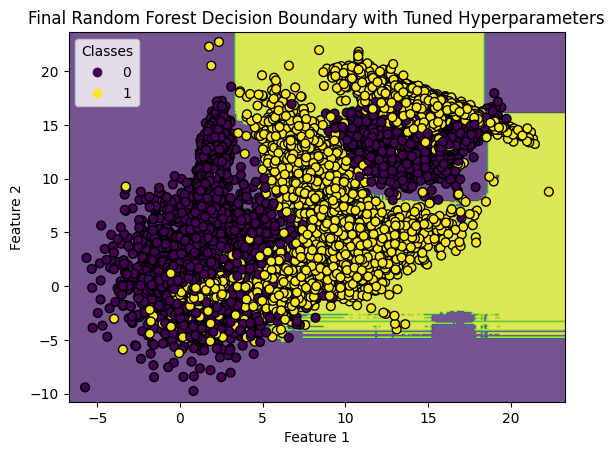

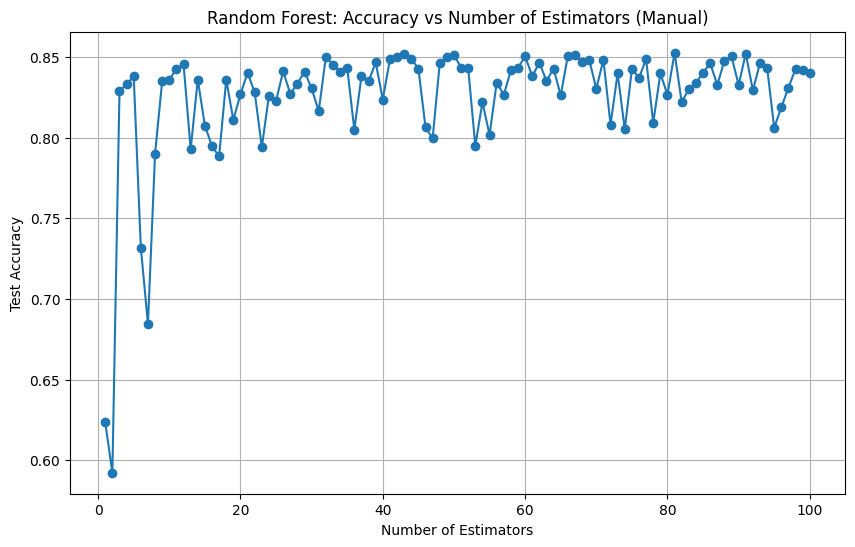

In [6]:
# Define Random Forest with hyperparameter tuning class
class ManualRandomForest:
    def __init__(self, base_estimator, n_estimators, max_features, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = []
        self.feature_subsets = []

    def fit(self, X, y):
        self.models = []
        self.feature_subsets = []
        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            X_sample, y_sample = bootstrap_sample(X, y)
            # Select a random subset of features
            feature_subset = random_feature_subset(X_sample, self.max_features)
            self.feature_subsets.append(feature_subset)
            # Train the base model on the selected features
            model = self.base_estimator(
                max_depth=self.max_depth, 
                min_samples_split=self.min_samples_split, 
                min_samples_leaf=self.min_samples_leaf
            )
            model.fit(X_sample[:, feature_subset], y_sample)
            self.models.append(model)

    def predict(self, X):
        # Collect predictions from all base models
        predictions = np.array([
            model.predict(X[:, feature_subset]) for model, feature_subset in zip(self.models, self.feature_subsets)
        ])
        # Use majority voting for final prediction
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# Random feature subset selection
def random_feature_subset(X, n_features):
    total_features = X.shape[1]
    selected_indices = np.random.choice(total_features, n_features, replace=True)
    return selected_indices

# Define hyperparameter tuning using GridSearch
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': [1, 2],
    'max_depth': [5, 10, 15],
    'min_samples_split':[10, 15, 20],
    'min_samples_leaf':[10, 15, 20]
}


best_params = None
best_accuracy = 0
rf_scores = []

for n_estimators in param_grid['n_estimators']:
    for max_features in param_grid['max_features']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    # Train the model with the current hyperparameters
                    rf_model = ManualRandomForest(
                        base_estimator=DecisionTreeClassifier, 
                        n_estimators=n_estimators, 
                        max_features=max_features,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf
                    )
                    rf_model.fit(X_train, y_train)
                    metrics = evaluate_model_manual(rf_model, X_train, y_train, X_test, y_test)

                    # Track the best hyperparameters
                    rf_scores.append((n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, metrics['Test Accuracy']))
                    if metrics['Test Accuracy'] > best_accuracy:
                        best_accuracy = metrics['Test Accuracy']
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_features': max_features,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }

print("Best Hyperparameters:", best_params)
print("Best Test Accuracy:", best_accuracy)


# Train the final model with the best hyperparameters
final_rf_model = ManualRandomForest(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=best_params['n_estimators'], 
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)

final_rf_model.fit(X_train, y_train)

# Evaluate the final model
metrics = evaluate_model_manual(final_rf_model, X_train, y_train, X_test, y_test)
print("Evaluation Metrics:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:<20}: {value:.4f}")
print("-" * 30)

# Visualize decision boundaries of individual trees
n_visualize = 5
for i in range(min(n_visualize, len(final_rf_model.models))):
    plt.figure(figsize=(6, 4))
    plot_decision_boundary(final_rf_model.models[i], X_train, y_train, 
                           title=f"Tree {i+1} Decision Boundary")
    plt.show()
    
# Visualize the final Random Forest decision boundary
plot_decision_boundary(final_rf_model, X_train, y_train, 
                          title="Final Random Forest Decision Boundary with Tuned Hyperparameters")

rf_scores = []
for n_estimators in range(1, 101):  # Test different numbers of estimators
    # print(f"Training Random Forest with {n_estimators} Estimators")
    rf_model = ManualRandomForest(base_estimator=DecisionTreeClassifier, n_estimators=n_estimators, max_features=2)
    rf_model.fit(X_train, y_train)
    metrics = evaluate_model_manual(rf_model, X_train, y_train, X_test, y_test)
    rf_scores.append((n_estimators, metrics["Test Accuracy"]))


# Plot accuracy vs number of estimators
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in rf_scores], [x[1] for x in rf_scores], marker='o')
plt.title("Random Forest: Accuracy vs Number of Estimators (Manual)")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()

**Phase 3**

In [16]:
# Define the parameter grid for AdaBoost
param_grid = {
    "n_estimators": [50, 80, 100],         # Number of weak learners
    "learning_rate": [ 0.1, 0.01, 1.0],    # Learning rate for updating weights
    "estimator__max_depth": [3, 5, 10],     # Depth of the weak learner (DecisionTreeClassifier)
    "algorithm": ["SAMME"]    # Boosting algorithm
}

# Create the AdaBoost model with a base DecisionTreeClassifier
base_estimator = DecisionTreeClassifier()
ada_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Extract the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

Best Parameters: {'algorithm': 'SAMME', 'estimator__max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100}


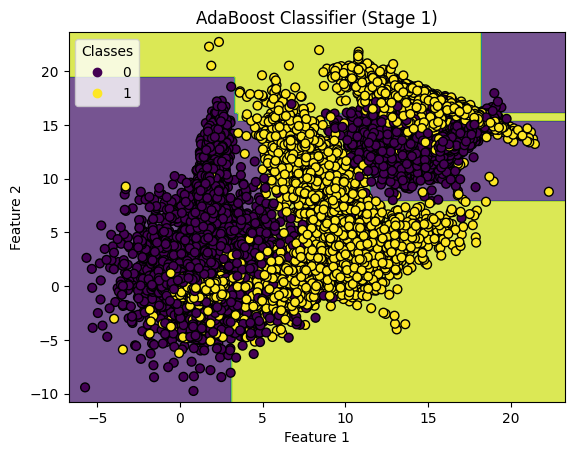

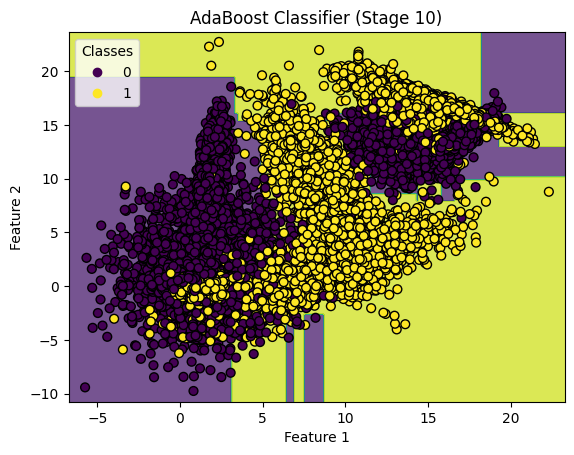

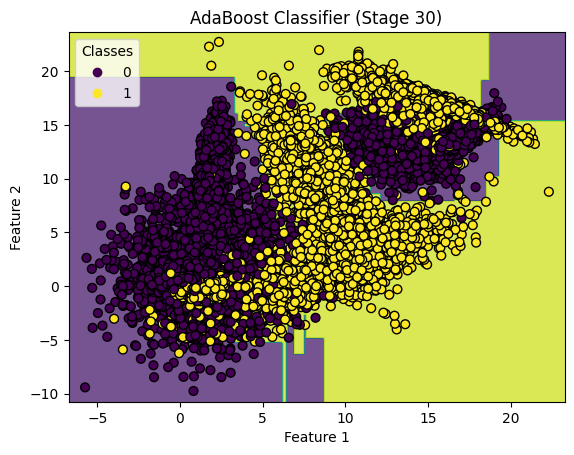

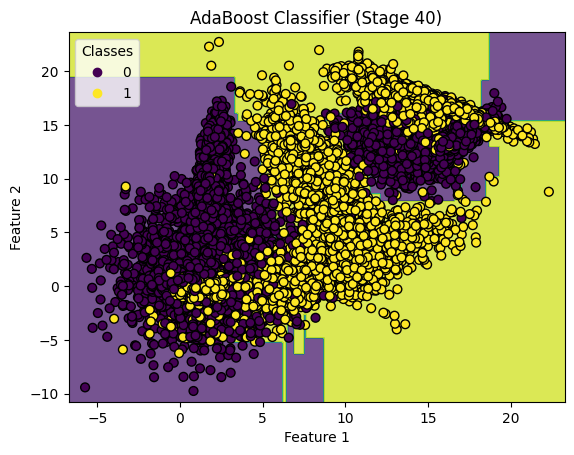

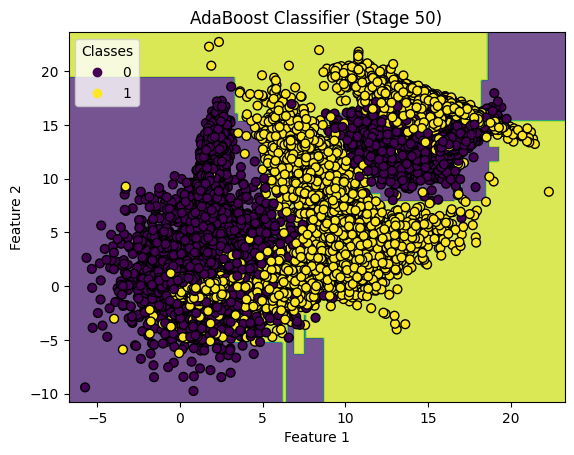

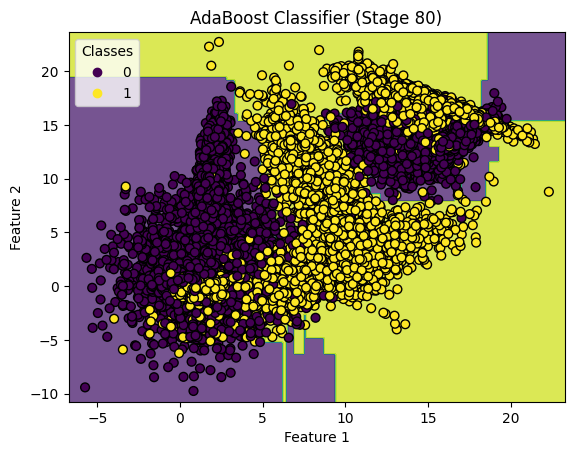

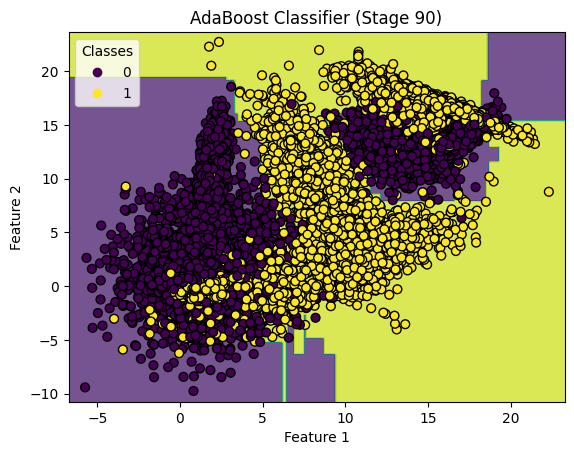

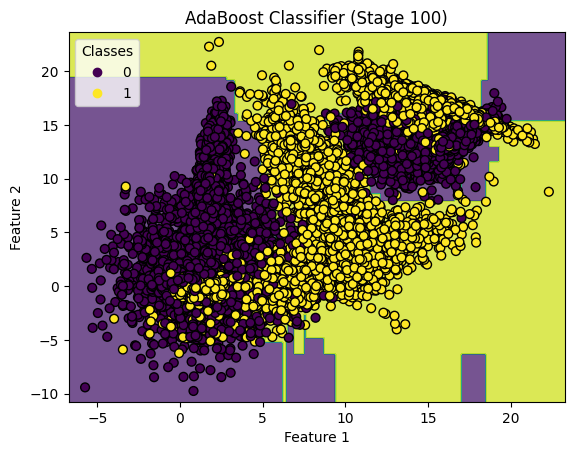

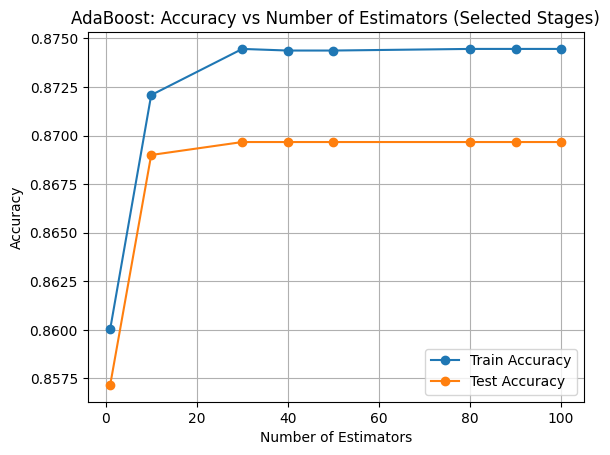

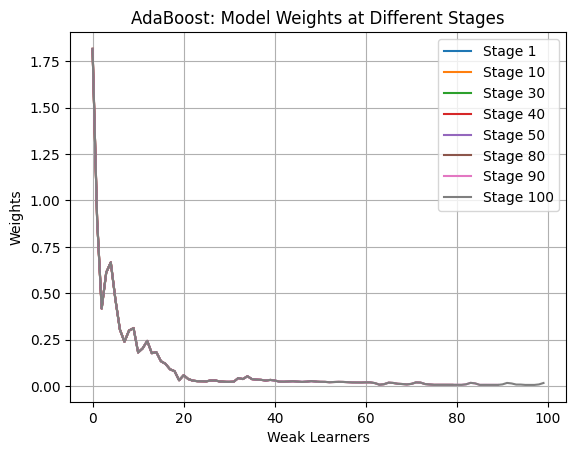

Best Parameters: {'algorithm': 'SAMME', 'estimator__max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100}
Final Model Evaluation Metrics:
------------------------------
Train Accuracy      : 0.8745
Test Accuracy       : 0.8697
Train Precision     : 0.8632
Test Precision      : 0.8561
Train Recall        : 0.8903
Test Recall         : 0.8871
Train F1 Score      : 0.8766
Test F1 Score       : 0.8713
------------------------------


In [19]:
selected_stages = [1, 10, 30, 40, 50, 80, 90, 100]

train_accuracies = []
test_accuracies = []

model_weights = []
weak_model_predictions = []

for n_estimators in selected_stages:  
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=5), 
        n_estimators=n_estimators, 
        learning_rate=1.0,
        random_state=42,
        algorithm="SAMME"
    )
    
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    model_weights.append(model.estimator_weights_) 
    weak_model_predictions.append([weak_model.predict(X_test) for weak_model in model.estimators_])
  
    plot_decision_boundary(model, X_train, y_train, title=f"AdaBoost Classifier (Stage {n_estimators})")
    plt.show()

# Drawing the diagram of accuracies in different stages
plt.plot(selected_stages, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(selected_stages, test_accuracies, label="Test Accuracy", marker='o')
plt.title("AdaBoost: Accuracy vs Number of Estimators (Selected Stages)")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Draw the weight changes in each step
for idx, stage in enumerate(selected_stages):
    plt.plot(model_weights[idx], label=f"Stage {stage}")
plt.title("AdaBoost: Model Weights at Different Stages")
plt.xlabel("Weak Learners")
plt.ylabel("Weights")
plt.legend()
plt.grid(True)
plt.show()

# Final Model Training
final_ad_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params["estimator__max_depth"]),
    n_estimators=best_params["n_estimators":],
    learning_rate=best_params["learning_rate"],
    algorithm=best_params["algorithm"],
        random_state=42
)

final_ad_model.fit(X_train, y_train)

metrics = evaluate_model_manual(final_ad_model, X_train, y_train, X_test, y_test)

print("Best Parameters:", best_params)

# Print the results
print("Final Model Evaluation Metrics:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:<20}: {value:.4f}")
print("-" * 30)

**Phase 4**

In [18]:
# Define base learners
base_learners = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression()),
    "SVC": make_pipeline(StandardScaler(), SVC(probability=True))
}

# Hyperparameter tuning for each base learner
tuned_learners = {}
param_grids = {
    "RandomForest": {"n_estimators": [30, 40, 50], "max_depth": [5, 10]},
    "GradientBoosting": {"n_estimators": [30, 40, 50], "learning_rate": [0.01, 0.1]},
    "LogisticRegression": {"logisticregression__C": [0.1, 1]},
    "SVC": {"svc__C": [0.1, 1, 10], "svc__kernel": ["linear"]}
}

for name, model in base_learners.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    tuned_learners[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Train base learners and create meta-features
meta_features_train = np.zeros((X_train.shape[0], len(base_learners)))
meta_features_test = np.zeros((X_test.shape[0], len(base_learners)))

for i, (name, model) in enumerate(tuned_learners.items()):
    model.fit(X_train, y_train)
    meta_features_train[:, i] = model.predict_proba(X_train)[:, 1]  # Use probabilities
    meta_features_test[:, i] = model.predict_proba(X_test)[:, 1]

# Train meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(meta_features_train, y_train)

# Evaluate the stacked model
y_train_pred = meta_learner.predict(meta_features_train)
y_test_pred = meta_learner.predict(meta_features_test)

metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train Precision": precision_score(y_train, y_train_pred),
    "Test Precision": precision_score(y_test, y_test_pred),
    "Train Recall": recall_score(y_train, y_train_pred),
    "Test Recall": recall_score(y_test, y_test_pred),
    "Train F1 Score": f1_score(y_train, y_train_pred),
    "Test F1 Score": f1_score(y_test, y_test_pred),
}

print("Stacked Model Evaluation:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:<20}: {value:.4f}")
print("-" * 30)

Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 50}
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 50}
Best parameters for LogisticRegression: {'logisticregression__C': 1}
Best parameters for SVC: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Stacked Model Evaluation:
------------------------------
Train Accuracy      : 0.9077
Test Accuracy       : 0.8687
Train Precision     : 0.9020
Test Precision      : 0.8575
Train Recall        : 0.9150
Test Recall         : 0.8827
Train F1 Score      : 0.9085
Test F1 Score       : 0.8699
------------------------------


In [22]:
# Define base learners
base_learners = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression()),
    "SVC": make_pipeline(StandardScaler(), SVC(probability=True))
}

# Hyperparameter tuning for each base learner
tuned_learners = {}
param_grids = {
    'Decision Tree': {'max_depth': [None], 'min_samples_split': [2]},
    "RandomForest": {"n_estimators": [30, 40, 50], "max_depth": [5, 10]},
    "GradientBoosting": {"n_estimators": [30, 40, 50], "learning_rate": [0.01, 0.1]},
    "LogisticRegression": {"logisticregression__C": [0.1, 1]},
    "SVC": {"svc__C": [0.1, 1, 10], "svc__kernel": ["linear"]}
}

for name, model in base_learners.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    tuned_learners[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create meta-features using cross-validation
meta_features_train = np.zeros((X_train.shape[0], len(base_learners)))
meta_features_test = np.zeros((X_test.shape[0], len(base_learners)))

for i, (name, model) in enumerate(tuned_learners.items()):
    fold_test_predictions = np.zeros((X_test.shape[0], skf.get_n_splits()))
    
    for j, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        model_clone = clone(model)
        model_clone.fit(X_train[train_idx], y_train[train_idx])
        
        # Generate meta-features for validation fold
        if hasattr(model_clone, "predict_proba"):
            meta_features_train[val_idx, i] = model_clone.predict_proba(X_train[val_idx])[:, 1]
            fold_test_predictions[:, j] = model_clone.predict_proba(X_test)[:, 1]
        else:
            meta_features_train[val_idx, i] = model_clone.predict(X_train[val_idx])
            fold_test_predictions[:, j] = model_clone.predict(X_test)
    
    # Average predictions for test data across folds
    meta_features_test[:, i] = fold_test_predictions.mean(axis=1)

# Train meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(meta_features_train, y_train)

# Evaluate the stacked model
y_train_pred = meta_learner.predict(meta_features_train)
y_test_pred = meta_learner.predict(meta_features_test)

metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train Precision": precision_score(y_train, y_train_pred),
    "Test Precision": precision_score(y_test, y_test_pred),
    "Train Recall": recall_score(y_train, y_train_pred),
    "Test Recall": recall_score(y_test, y_test_pred),
    "Train F1 Score": f1_score(y_train, y_train_pred),
    "Test F1 Score": f1_score(y_test, y_test_pred),
}

print("Stacked Model Evaluation:")
print("-" * 30)
for metric, value in metrics.items():
    print(f"{metric:<20}: {value:.4f}")
print("-" * 30)

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 30}
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 50}
Best parameters for LogisticRegression: {'logisticregression__C': 1}
Best parameters for SVC: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Stacked Model Evaluation:
------------------------------
Train Accuracy      : 0.8745
Test Accuracy       : 0.8725
Train Precision     : 0.8656
Test Precision      : 0.8588
Train Recall        : 0.8871
Test Recall         : 0.8901
Train F1 Score      : 0.8762
Test F1 Score       : 0.8742
------------------------------
